# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

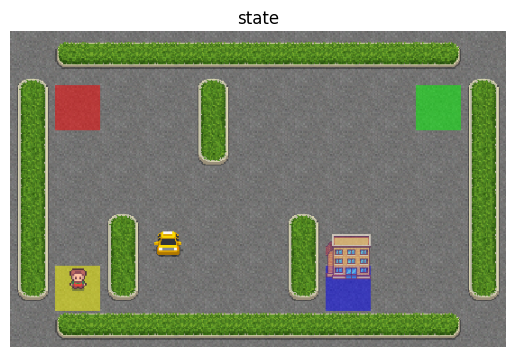

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

def show(title=""):
    global env
    plt.imshow(env.render())
    plt.axis('off')
    plt.title(title)
    plt.show()

env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()
n_states = env.observation_space.n # type: ignore
n_actions = env.action_space.n     # type: ignore

show("state")


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


# Initialize policy (0.5pts)

In [2]:
policy = np.ones((n_states, n_actions)) / n_actions

assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)

print("Ok!")

Ok!


# Play the game (0.5pts)

Just like before, but we also record all states and actions we took.

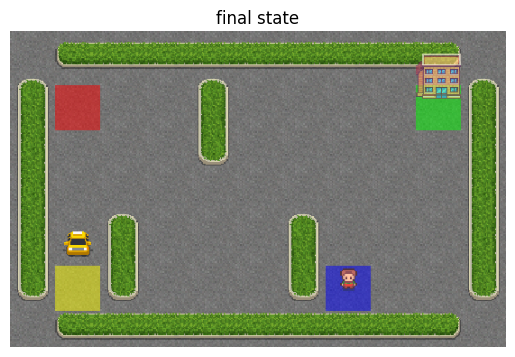

In [3]:
def generate_session(policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.0
    
    s, _ = env.reset()
    
    rand_act = 0.5
    q = 0.99

    for t in range(t_max):
        rand_act *= q
        if np.random.uniform(0, 1) < rand_act:
            a = np.random.choice(range(n_actions))
        else:
            a = np.random.choice(range(n_actions), p = policy[s])
        
        new_s, r, done, done2, _ = env.step(a)
        # new_s - новое состояние
        # r - награда
        # done - завершили или нет
        # info - оно нам не надо
        # _ - тоже не надо

        
        #Record state, action and add up reward to states,actions and total_reward accordingly. 
        #add state
        #add action
        #add reward
        states.append(s)
        actions.append(a)
        total_reward += float(r)
        
        s = new_s
        if done or done2:
            break
    return states, actions, total_reward

s, a, r = generate_session(policy, 10**4)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float]

show("final state")
        

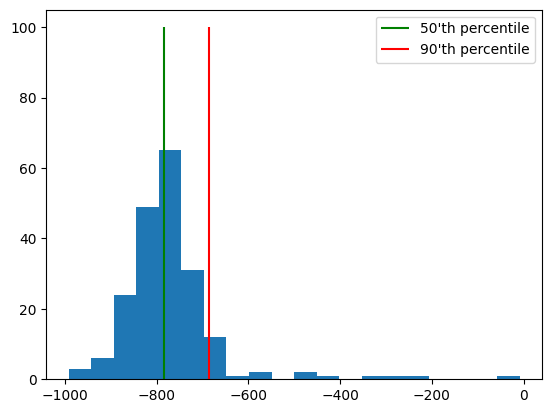

In [4]:
#let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20)
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label="50'th percentile",color='green')
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label="90'th percentile",color='red')
plt.legend()
plt.show()

### Crossentropy method steps (1pts)

In [5]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """ 
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states, elite_actions = [], []

    # print(len(states_batch))
    # print(len(actions_batch))
    # print(len(rewards_batch))

    n = len(rewards_batch)
    # print(reward_threshold)

    for i in range(n):
        if rewards_batch[i] >= reward_threshold:
            for x in states_batch[i]:
                elite_states.append(x)
            for x in actions_batch[i]:
                elite_actions.append(x)
    return elite_states, elite_actions    


states_batch = np.array([np.array([1,2,3]), np.array([4,2,0,2]), np.array([3,1])], dtype=np.ndarray)

actions_batch = np.array([np.array([0,2,4]), np.array([3,2,0,1]), np.array([3,3])], dtype=np.ndarray)
rewards_batch = np.array([3, 4, 5])

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

print(test_result_40)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

([np.int64(4), np.int64(2), np.int64(0), np.int64(2), np.int64(3), np.int64(1)], [np.int64(3), np.int64(2), np.int64(0), np.int64(1), np.int64(3), np.int64(3)])
Ok!


In [6]:
def update_policy(elite_states, elite_actions):
    global n_states, n_actions
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to
    
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    
    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions
    
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions
    
    """
    
    new_policy = np.zeros((n_states, n_actions))

    for i in range(len(elite_states)):
        st = elite_states[i]
        act = elite_actions[i]

        new_policy[st][act] += 1
    
    for i in range(n_states):
        sm = np.sum(new_policy[i])
        if sm == 0.0:
            new_policy[i] = np.ones(n_actions) / n_actions
        else:
            new_policy[i] /= sm
    
    return new_policy

elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states, elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
print(new_policy[:4,:5])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

[[1.         0.         0.         0.         0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.33333333 0.66666667 0.         0.        ]
 [0.         0.         0.         0.5        0.5       ]]
Ok!


# Training loop (1pts)
Generate sessions, select N best and fit to those.

mean reward = -206.407, threshold=-142.000


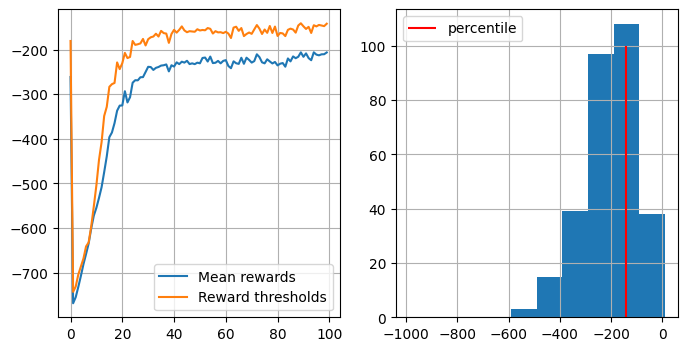

In [9]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def show_progress(rewards_batch,log, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(rewards_batch,range=reward_range)
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()

#reset policy just in case
policy = np.ones((n_states, n_actions)) / n_actions


n_sessions = 300  #sample this many sessions
percentile = 70  #take this percent of session with highest rewards
learning_rate = 0.3  #add this thing to all counts for stability

log = []

for i in range(100):
    clear_output(True)
    show_progress(rewards_batch,log)

    sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(np.array(states_batch,  dtype=np.ndarray),
                                                np.array(actions_batch, dtype=np.ndarray),
                                                np.array(rewards_batch, dtype=np.ndarray), 
                                                percentile)
    
    new_policy = update_policy(elite_states, elite_actions)

    policy = policy * (1 - learning_rate) + new_policy * learning_rate
    
    #display results on chart

# Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples. Show all precentiles on one graph and all n_samples on another
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


In [10]:
import gym
import numpy as np, pandas as pd

np.bool8 = np.bool_
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()
n_states = env.observation_space.n
n_actions = env.action_space.n
policy = 1/6. * np.ones([n_states, n_actions])
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
# assert type(r) in [float,np.float]
policy = np.ones([n_states,n_actions])/n_actions 
stepCounter = 40

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


percentile 10 done!
percentile 20 done!
percentile 30 done!
percentile 40 done!
percentile 50 done!
percentile 60 done!
percentile 70 done!
percentile 80 done!


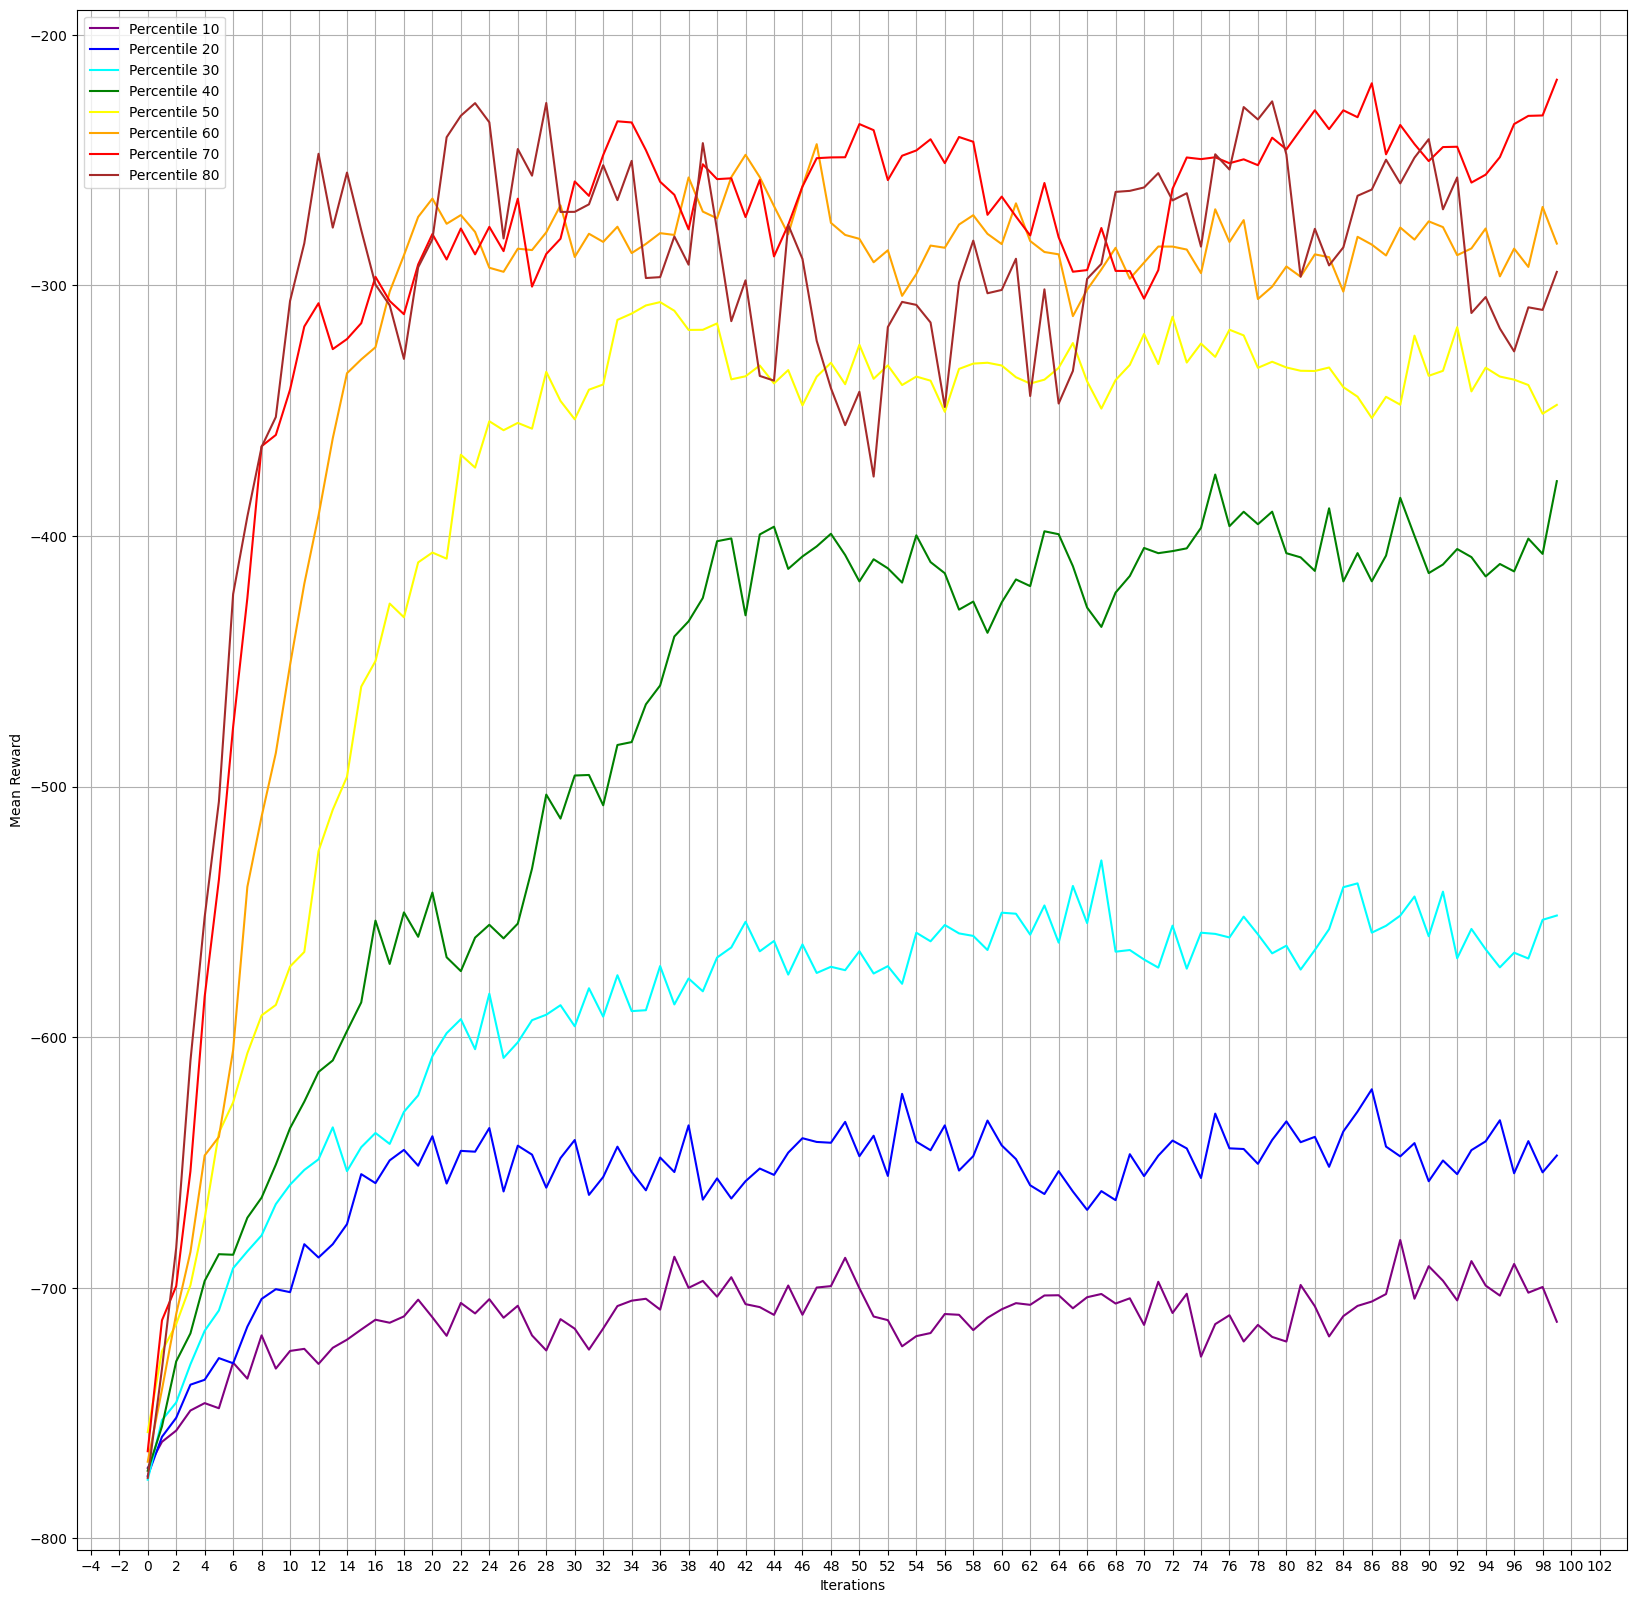

In [11]:
from matplotlib.ticker import MultipleLocator


n_sessions = 250
percentiles = [10, 20, 30, 40, 50, 60, 70, 80]
color = ['purple', 'blue', 'cyan', 'green', 'yellow', 'orange', 'red', 'brown']
learning_rate = 0.5
stepCounter = 100

log = []
mean = []

fig, ax = plt.subplots(figsize=(20,20))

ax.set_xlabel('Iterations')
ax.set_ylabel('Mean Reward')

for percentile in percentiles:
    curMean = []
    policy = np.ones([n_states,n_actions])/n_actions

    for i in range(stepCounter):

        sessions = [generate_session(policy) for _ in range(n_sessions)]

        states_batch,actions_batch,rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(np.array(states_batch, dtype=np.ndarray),np.array(actions_batch, dtype=np.ndarray),np.array(rewards_batch, dtype=np.ndarray),percentile=percentile)

        new_policy = update_policy(elite_states, elite_actions)
        policy = policy * (1 - learning_rate) + new_policy * learning_rate

        curMean.append(np.mean(rewards_batch))

    mean.append(curMean)
    print(f"percentile {percentile} done!")

for percentile in percentiles:
    ax.plot(range(stepCounter), mean[percentiles.index(percentile)], label=f'Percentile {percentile}', color=color[percentiles.index(percentile)])

ax.legend()
ax.grid()
ax.xaxis.set_major_locator(MultipleLocator(base=2))

plt.show()


# How do different percentiles affect training efficiency?

чем выше персентиль, тем лучше обучение, при слишком большом персентиле (например 80) моделька начинает сильно деградировать

n_sessions 100 done!
n_sessions 200 done!
n_sessions 300 done!
n_sessions 400 done!
n_sessions 500 done!


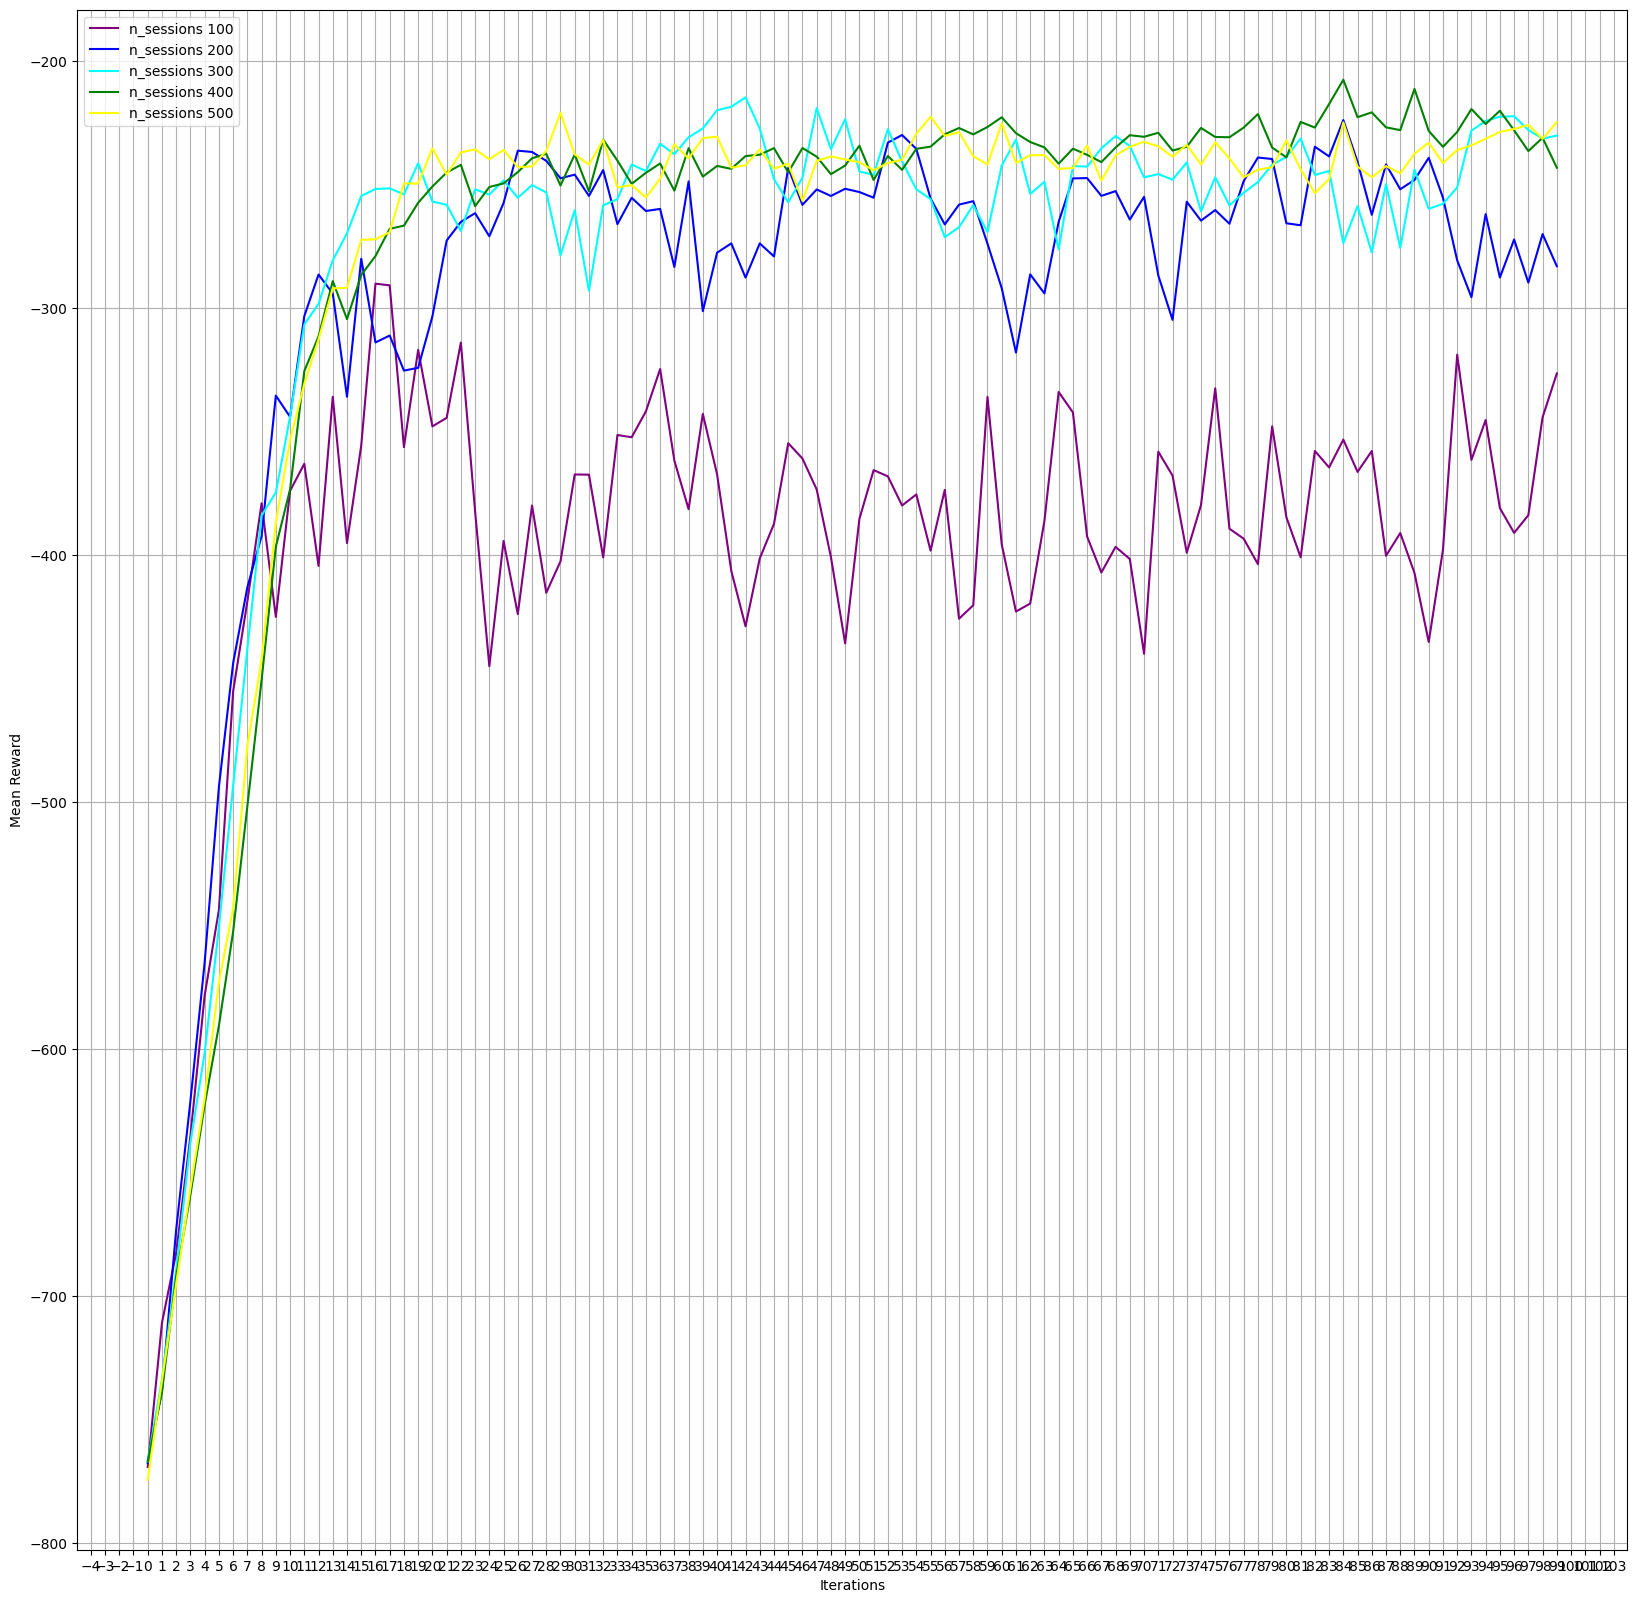

In [12]:
n_sessions_ar = [100, 200, 300, 400, 500]  #sample this many sessions
perc = 70  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []
mean = []

fig, ax = plt.subplots(figsize=(20,20))

ax.set_xlabel('Iterations')
ax.set_ylabel('Mean Reward')

for n_sessions in n_sessions_ar:
    curMean = []
    policy = np.ones([n_states,n_actions])/n_actions
    for i in range(stepCounter):

        sessions = [generate_session(policy) for _ in range(n_sessions)]

        states_batch,actions_batch,rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(np.array(states_batch, dtype=np.ndarray),np.array(actions_batch, dtype=np.ndarray),np.array(rewards_batch, dtype=np.ndarray),percentile=perc)

        new_policy = update_policy(elite_states, elite_actions)
        policy = policy * (1 - learning_rate) + new_policy * learning_rate

        curMean.append(np.mean(rewards_batch))
    mean.append(curMean)
    print(f"n_sessions {n_sessions} done!")

for n_sessions in n_sessions_ar:
    ax.plot(range(stepCounter), mean[n_sessions_ar.index(n_sessions)], label=f'n_sessions {n_sessions}', color=color[n_sessions_ar.index(n_sessions)])

ax.legend()
ax.grid()
ax.xaxis.set_major_locator(MultipleLocator(base=1))

plt.show()

# Stabilize positive rewards by averaging policy across 10 games (2 pts)

mean reward = 16.384, threshold=16.800


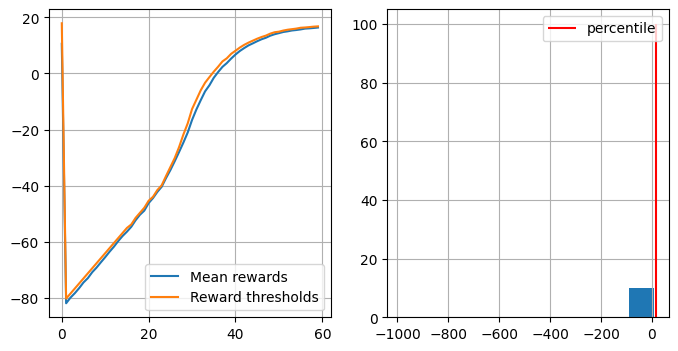

cur step is 59
win!


In [14]:
n_sessions = 1000  #sample this many sessions
percentile = 60  #take this percent of session with highest rewards
learning_rate = 0.3  #add this thing to all counts for stability
stepCounter = 60

def generate_session(policy, t_max=10**4):
    states, actions = [], []
    total_reward = 0.0
    rand_act = 0.5
    q = 0.99
    
    s, _ = env.reset()
    for i in range(10):
        for t in range(t_max):
            rand_act *= q
            # if np.random.uniform(0, 1) < rand_act:
            #    a = np.random.choice(range(n_actions))
            #else:
            a = np.random.choice(range(n_actions), p = policy[s])
            
            new_s, r, done, done2, _ = env.step(a)

            states.append(s)
            actions.append(a)
            total_reward += float(r)
            
            s = new_s
            if done or done2:
                break
    return states, actions, total_reward / 10.0

log = []
mean = []
policy = np.ones([n_states,n_actions])/n_actions
max_r = -9999
for i in range(stepCounter):
    clear_output(True)

    show_progress(rewards_batch,log)
    print(f"cur step is {i}")

    sessions = [generate_session(policy) for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(np.array(states_batch, dtype=np.ndarray),np.array(actions_batch, dtype=np.ndarray),np.array(rewards_batch, dtype=np.ndarray),percentile=percentile)

    new_policy = update_policy(elite_states, elite_actions)
    policy = policy * (1 - learning_rate) + new_policy * learning_rate
    max_r = max(max_r, np.mean(rewards_batch))

if max_r > 7:
    print("win!")

# Digging deeper: approximate crossentropy with neural nets (2 pts)

In this section we will train a neural network policy for continuous state space game

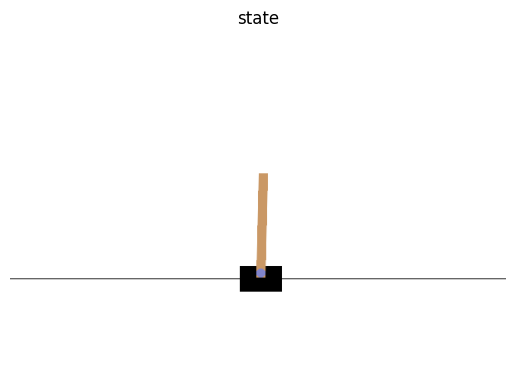

In [15]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def show(title=""):
    global env
    plt.imshow(env.render())
    plt.axis('off')
    plt.title(title)
    plt.show()

env = gym.make("CartPole-v1", render_mode="rgb_array")  #if you see "<classname> has no attribute .env", remove .env or update gym
env.reset()
n_actions = env.action_space.n

show("state")

In this case use NN as a black box. All your should know that it is more complex than a tabular method. 

In [16]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()[0]]*n_actions,range(n_actions))


/opt/anaconda3/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20), max_iter=1,
              warm_start=True)

In [17]:
def generate_session(t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()[0]
    
    for t in range(t_max):
        
        #predict array of action probabilities hint: predict_proba
        probs = agent.predict_proba([s])[0]
        #print(probs)
        
        a = np.random.choice(np.arange(n_actions), p=probs)
        
        new_s,r,done,done2,_ = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done or done2: 
            break
    return states,actions,total_reward

s,a,r=generate_session()
print(r)
        

40.0


In [18]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """ 
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states, elite_actions = [], []

    n = len(rewards_batch)

    for i in range(n):
        if rewards_batch[i] >= reward_threshold:
            for x in states_batch[i]:
                elite_states.append(x)
            for x in actions_batch[i]:
                elite_actions.append(x)
    return elite_states, elite_actions    
    

To train this classification model use fit(states, actions). In this case we are training classificator to predict the correct class (action) in a given state

mean reward = 192.430, threshold=223.300


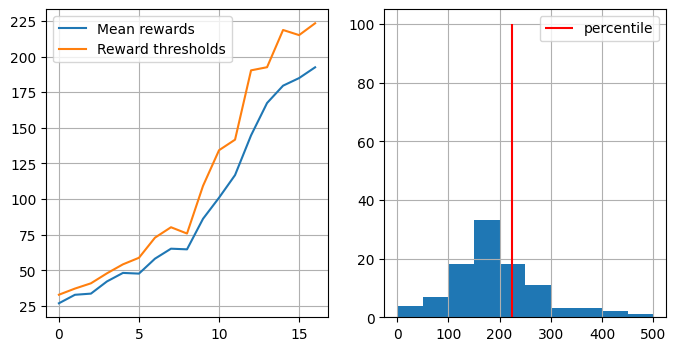

You Win! You may stop training now via KeyboardInterrupt.


In [19]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    #generate new sessions
    sessions = [generate_session() for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = zip(*sessions)
    # print(states_batch.shape)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile=50)
    
    #fit agent

    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch,log,reward_range=[0,np.max(rewards_batch)])
    
    if np.mean(rewards_batch)> 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

# Report (1 pts)

1 задача:
сделали 2 графика: изменение Mean Reward в зависимости от Percentile и n_samples. Чем выше персентиль, тем быстрее обучение и выше стабильность при бОльших итерациях. Также при слишком высоком персентиле (80+) стабильность также сильно проседает при бОльших итерациях. Идеальнее всего персентиль 60-70. По n_samples: чем больше n_samples, тем стабильнее обучение, но и тем дольше оно происходит. При n_samples=1000 обучение стабильно, но долгое. При n_samples=100 - быстрое, но нестабильное.

2 задача: агент обучался с помощью sk.neural_network.MLPClassifier, уже в первые итерации mean reward сильно пошел вверх даже без всяких оптимизаций. 